In [1]:
pwd

'/data2/mito_lineage/notebooks/CHIP_april08_2021_Croker/MTblacklist'

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 


In [3]:
import os
from os.path import join
import pandas as pd
from src.config import RESULTS, FIGURES_DIR, ROOT_DIR
#from src.calculate_AF_by_cell import calculate_af
#ref_fa = "/data2/genome/human_GRCh38/cellranger/refdata-cellranger-GRCh38-3.0.0/fasta/genome.fa"
#ref_fa="/data2/mito_lineage/BWA-Primers-MT/MT_genome/MT.fasta"
maxBP = 16571

import glob
import numpy as np

Project Directory: /data2/mito_lineage


In [4]:
from matplotlib_venn import venn2

import seaborn as sns
import matplotlib.pyplot as plt

from mplh import cluster_help

In [5]:
os.chdir(ROOT_DIR)

## Files setup

#### Keep variants greater than mean heteroplasmy minimum parameter 'het'

In [6]:
het = 0.001

In [7]:
samples=["Control", "Flt3l", "Input"]
indir=join(RESULTS,"mttrace")
mapq = "MT"
num_reads = 200
cellr="True"
in_prefix = f'CHIP_april08_2021_Croker/MTblacklist'
filt_id = "minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20"

In [14]:
indirs={}
concat_dirs={}
filter_mgatk_variants = {}
afs={}
mgatk_afs = {}
for s in samples:
    indirs[s] = join(indir, in_prefix, s,mapq,f"cellr_{cellr}")
    concat_dirs[s] = join(indirs[s],f"{s}_{num_reads}")
    filter_mgatk_variants[s] = join(concat_dirs[s], "filters",filt_id,"filter_mgatk")
    afs[s] = pd.read_csv(join(filter_mgatk_variants[s], f"{s}.af.tsv"),sep="\t")
    mgatk_afs[s] = pd.read_csv(join(filter_mgatk_variants[s], f"{s}.af.mgatk.tsv"),sep="\t")
    afs[s] = afs[s].loc[mgatk_afs[s].index]
    print(f"Number of variants after mean heteroplasmy of {het}: {mgatk_afs[s].shape[0]}")

## Add labels to the names
for s in afs:
    afs[s].columns = afs[s].columns + f"_{s}"
all_cells = pd.concat(list(afs.values()), axis=1)

Number of variants after mean heteroplasmy of 0.001: 123
Number of variants after mean heteroplasmy of 0.001: 256
Number of variants after mean heteroplasmy of 0.001: 173


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [15]:
all_cells

,AAACTGCTCTCGCGGA-1_Control,AAAGATGCAGCAACGA-1_Control,AAAGGATGTGCTGTGC-1_Control,AAAGGATTCAAAGTAG-1_Control,AAATGCCCAGAAAGAG-1_Control,AAATGCCGTAAGGTCG-1_Control,AACAAAGAGCGATACG-1_Control,AACAAAGTCAGAGTGG-1_Control,AACAAAGTCTTACGGA-1_Control,AACATCGCATCGAGTT-1_Control,...,TTCGGTCTCTCTTCCT-1_Input,TTGCAGAAGTACGACG-1_Input,TTGCGAACATGGATGG-1_Input,TTGCTATTCCCGTAGG-1_Input,TTGCTTAGTATTCTCT-1_Input,TTGCTTATCGGTTCCT-1_Input,TTGTCTAAGCACGTAG-1_Input,TTTACGTCAGCCACGT-1_Input,TTTGAGGTCTGGGCGT-1_Input,TTTGCGCGTTGAATAG-1_Input
10302A>T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10398A>G,0.0,0.0,0.000000,0.951595,0.0,1.0,0.000000,1.0,0.0,1.0,...,0.00000,0.104439,0.018799,0.000000,0.000000,0.001452,0.458447,0.003831,0.016747,0.000000
103G>A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10400C>T,0.0,0.0,0.000000,0.945312,0.0,1.0,0.000000,1.0,0.0,1.0,...,0.00000,0.108571,0.018930,0.000000,0.000000,0.001550,0.441512,0.004108,0.015044,0.000000
1040T>C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9545A>G,0.0,0.0,0.001871,0.996065,0.0,1.0,0.000000,1.0,0.0,1.0,...,0.00214,0.115965,0.020828,0.000429,0.000000,0.000000,0.465913,0.001287,0.000000,0.000000
9590A>T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9640C>T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983C>T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
variants_set = dict()
for s in mgatk_afs:
    variants_set[s] = mgatk_afs[s].index


## Get type of variant information

In [19]:
import src.utils.variant_utils as vu

In [20]:
variant_df = vu.type_of_variants(all_cells.index.values)
variant_positions = list(map(lambda x: int(x[:-3]), all_cells.index))
variant_df

variants
['10302A>T' '10398A>G' '103G>A' '10400C>T' '1040T>C' '10463T>C' '10516T>A'
 '10559A>G' '10571A>T' '10626T>C' '10646G>A' '10671G>A' '1082A>G'
 '10873T>C' '11137T>C' '11204T>A' '11204T>C' '11238T>C' '11251A>G'
 '11332C>T' '11339T>C' '1134G>A' '11382C>A' '11467A>G' '11655C>G'
 '11684T>C' '11689C>T' '11711G>A' '11719G>A' '1174T>C' '11812A>G'
 '11838T>A' '11914G>A' '1192C>A' '11944T>C' '1199G>T' '12079C>T'
 '12105T>C' '12283G>A' '12283G>T' '12297T>C' '12308A>G' '12372G>A'
 '1252G>A' '12705C>T' '12723A>C' '12723A>G' '12736G>A' '12790T>A'
 '12790T>C' '12913T>C' '1291T>C' '12944T>A' '13042G>A' '13053C>A'
 '13063G>A' '13094T>A' '13108T>A' '13121G>A' '13246T>A' '13246T>C'
 '13263A>G' '13263A>T' '13305C>T' '13339T>A' '1334G>A' '13368G>A'
 '13369T>C' '13422A>T' '13436C>A' '13443T>A' '13443T>C' '13619T>A'
 '13781T>C' '13850A>T' '13931T>C' '14050T>C' '14233A>G' '14274A>G'
 '14318T>C' '14524A>C' '14614A>T' '14620C>T' '146T>C' '1471A>G' '1471A>T'
 '14766C>T' '14783T>C' '14861G>A' '14905G>A' '

,position,ref,alt,variant type,variant change
10302A>T,10302,A,T,Transversion,A>T
10398A>G,10398,A,G,Transition,A>G
103G>A,103,G,A,Transition,G>A
10400C>T,10400,C,T,Transition,C>T
1040T>C,1040,T,C,Transition,T>C
...,...,...,...,...,...
9545A>G,9545,A,G,Transition,A>G
9590A>T,9590,A,T,Transversion,A>T
9640C>T,9640,C,T,Transition,C>T
983C>T,983,C,T,Transition,C>T


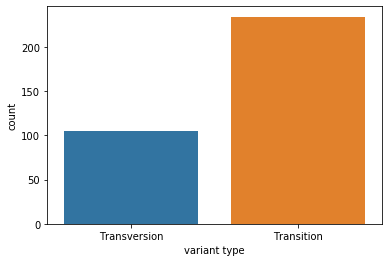

In [21]:
%matplotlib inline
sns.countplot(variant_df["variant type"])

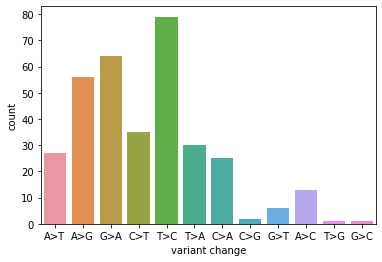

In [22]:
%matplotlib inline
sns.countplot(variant_df["variant change"])

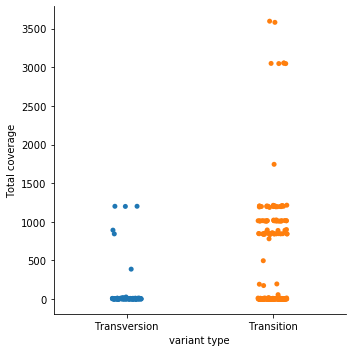

In [27]:
sns.catplot(x="variant type",y="Total coverage",
            data=pd.concat((variant_df,all_cells.fillna(0).sum(axis=1)), axis=1).rename({0:"Total coverage"}, axis=1))

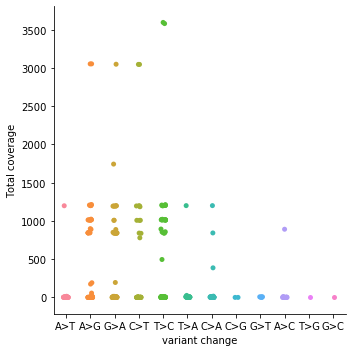

In [28]:
sns.catplot(x="variant change",y="Total coverage",
            data=pd.concat((variant_df,all_cells.sum(axis=1)), axis=1).rename({0:"Total coverage"}, axis=1))

In [ ]:
cells_meta = pd.DataFrame([x.split("_")[-1] for x in all_cells.columns], columns=["Condition"])
cells_meta

In [30]:
cluster_help.plot_cluster(df=all_cells.fillna(0).transpose(), 
                 fsave=None, to_z=False, to_col_clust=False, row_meta=pd.DataFrame(cell_colors, columns=["Sample"]),
                 to_row_clust=False, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None, metric='jaccard')

NameError: name 'cell_colors' is not defined

clustering
cmap None


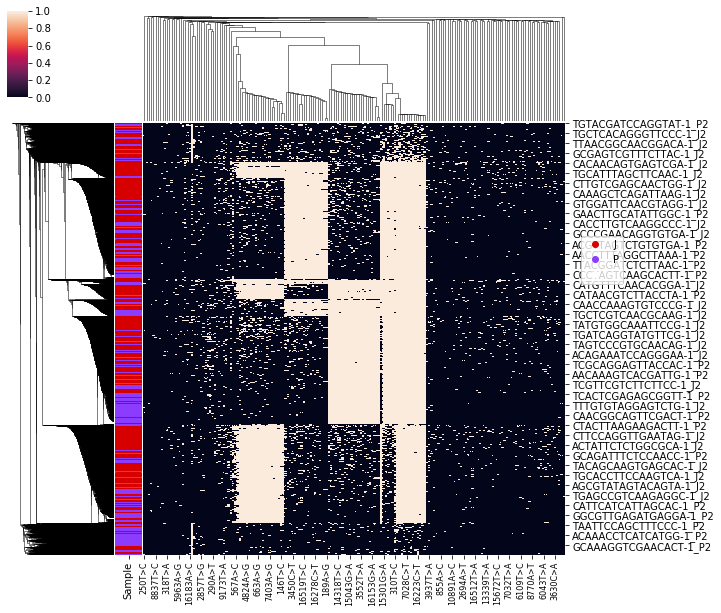

In [24]:
cluster_help.plot_cluster(df=all_cells.fillna(0).transpose(), 
                 fsave=None, to_z=False, to_col_clust=True, row_meta=pd.DataFrame(cell_colors, columns=["Sample"]),
                 to_row_clust=True, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None, metric='jaccard')

## Relate this to coverage

In [25]:
J2_depth = pd.read_csv(join(filter_mgatk_variants_J2,"J2_lowC10.coverage.tsv"), index_col=0, sep='\t')
J2_depth.columns = np.arange(1, J2_depth.shape[1]+1)
P2_depth = pd.read_csv(join(filter_mgatk_variants_P2,"P2_lowC10.coverage.tsv"), index_col=0,sep='\t')
P2_depth.columns = np.arange(1, P2_depth.shape[1]+1)
J2_depth.index = J2_depth.index + "_J2"
P2_depth.index = P2_depth.index + "_P2"

Text(0.5, 1.0, 'P2 log10 cell total coverage over all variants called')

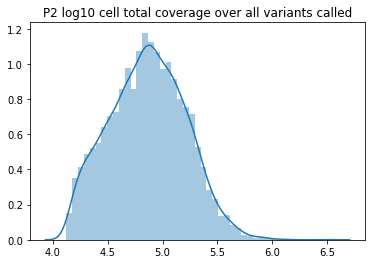

In [26]:
sns.distplot(np.log10(P2_depth.sum(axis=0)+1))
plt.title("P2 log10 cell total coverage over all variants called")

Text(0.5, 1.0, 'J2 log10 cell total coverage over all variants called')

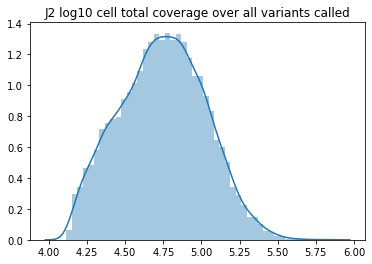

In [27]:
sns.distplot(np.log10(J2_depth.sum(axis=0)+1))
plt.title("J2 log10 cell total coverage over all variants called")

In [28]:
P2_depth = P2_depth.loc[~((P2_depth.sum(axis=1)==0))]


In [29]:
J2_depth = J2_depth.loc[~((J2_depth.sum(axis=1)==0))]


clustering
cmap None


Text(0.5, 1, 'J cells-by-Position Depth')

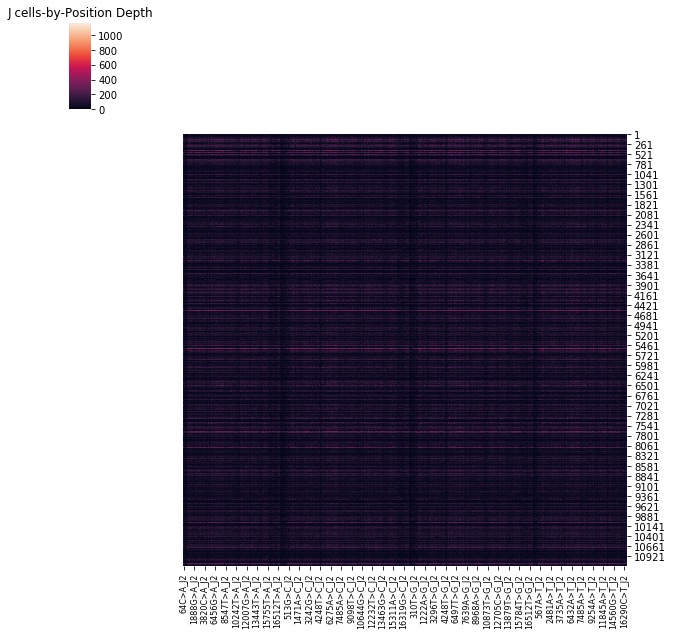

In [30]:
%matplotlib inline
cluster_help.plot_cluster(df=(J2_depth.transpose()), row_meta=None, col_meta=None,
                 fsave=None, to_z=False, to_col_clust=False,
                 to_row_clust=False, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None, metric='jaccard')
plt.title("J cells-by-Position Depth")
#plt.savefig(join(outdir,"J2_variants.png"))

## AF-Depth in same positions

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


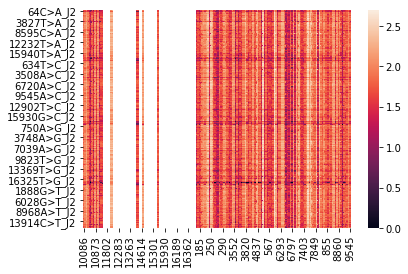

In [31]:
sns.heatmap(np.log10(J2_depth.loc[:, variant_positions]+1))

In [32]:

all_cells_depth = pd.concat((J2_depth.transpose(),P2_depth.transpose()) ,axis=1).transpose()
# cluster_help.plot_cluster(df=all_cells_depth, 
#                  fsave=None, to_z=False, to_col_clust=False, row_meta=pd.DataFrame(cell_colors, columns=["Sample"]),
#                  to_row_clust=False, name=None, col_names=True,
#                  row_names=True, to_legend=True, method="average", white_name=None, metric='jaccard')

In [42]:
all_cells_depth.reset_index(drop=True)

,1,2,3,4,5,6,7,8,9,10,...,11166,11167,11168,11169,11170,11171,11172,11173,11174,11175
0,78.0,107.0,117.0,64.0,238.0,41.0,101.0,72.0,108.0,45.0,...,148.0,71.0,70.0,52.0,119.0,68.0,42.0,29.0,201.0,70.0
1,81.0,96.0,138.0,53.0,210.0,37.0,102.0,80.0,106.0,46.0,...,155.0,80.0,80.0,43.0,105.0,67.0,44.0,23.0,188.0,70.0
2,33.0,56.0,73.0,30.0,114.0,28.0,67.0,28.0,30.0,18.0,...,77.0,27.0,39.0,10.0,113.0,30.0,14.0,10.0,142.0,28.0
3,17.0,51.0,47.0,19.0,77.0,22.0,66.0,24.0,36.0,17.0,...,54.0,22.0,14.0,4.0,81.0,48.0,15.0,11.0,100.0,30.0
4,15.0,50.0,43.0,17.0,88.0,14.0,52.0,26.0,52.0,18.0,...,34.0,21.0,16.0,4.0,75.0,50.0,19.0,15.0,85.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,123.0,244.0,22.0,80.0,69.0,44.0,39.0,427.0,69.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1862,128.0,284.0,38.0,132.0,75.0,53.0,38.0,567.0,45.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1863,120.0,252.0,38.0,136.0,77.0,52.0,34.0,512.0,49.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1864,95.0,254.0,20.0,126.0,65.0,50.0,22.0,567.0,43.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
cluster_help.plot_cluster(df=np.log10(all_cells_depth.reset_index(drop=True).transpose().loc[:,variant_positions]), 
                 fsave=None, to_z=False, to_col_clust=False, row_meta=pd.DataFrame(cell_colors, columns=["Sample"]),
                 to_row_clust=False, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None, metric='jaccard')

/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


clustering
cmap None


KeyError: "None of [Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,\n               10,\n            ...\n            11166, 11167, 11168, 11169, 11170, 11171, 11172, 11173, 11174,\n            11175],\n           dtype='int64', length=11175)] are in the [index]"

<Figure size 720x720 with 0 Axes>

In [39]:
cluster_help.plot_cluster(df=np.log10(all_cells_depth.loc[:, variant_positions]+1), 
                 fsave=None, to_z=False, to_col_clust=False, row_meta=pd.DataFrame(cell_colors, columns=["Sample"]),
                 to_row_clust=True, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None)

clustering
cmap None


KeyError: "None of [Index(['64C>A_J2', '103G>A_J2', '146T>A_J2', '185G>A_J2', '204T>A_J2',\n       '310T>A_J2', '318T>A_J2', '489T>A_J2', '513G>A_J2', '634T>A_J2',\n       ...\n       '16230A>T_P2', '16278C>T_P2', '16290C>T_P2', '16319G>T_P2',\n       '16327C>T_P2', '16387A>T_P2', '16441A>T_P2', '16463A>T_P2',\n       '16497A>T_P2', '16525A>T_P2'],\n      dtype='object', length=1866)] are in the [index]"

<Figure size 720x720 with 0 Axes>

## Collect only the high AFs
80% of cells > 0.8 AF

In [ ]:
all_cells_af = pd.concat((J2_AF_by_cell,P2_AF_by_cell) ,axis=1)
all_cells_af = all_cells_af.fillna(0)
overlap_variants = all_cells_var_overlap.columns.values

cell_thresh = 0.8*all_cells.shape[1]
high_af_cells = all_cells[(all_cells > 0.8).sum(axis=1)>cell_thresh]
variants_meta = pd.DataFrame(list(map(lambda x: [x[:-3], *(x[-3:].split(">"))], high_af_cells.index)), columns=["Position", "Reference", "Alternative"], index=high_af_cells.index)
high_af_cells

In [ ]:
variants_meta.head()

In [ ]:
cluster_help.plot_cluster(df=high_af_cells.transpose(), 
                 fsave=None, to_z=False, to_col_clust=True, row_meta=pd.DataFrame(cell_colors, columns=["Sample"]),
                 to_row_clust=True, name=None, col_names=True,
                 row_names=True, to_legend=True, method="average", white_name=None)

In [ ]:
# sparse_P2_df = pd.read_csv(join(P2_indir, f"{P2}_{num_reads}", f"{P2}.A.strands.txt.gz"), header=None)
# sparse_P2_df["Nt"] = "A"
# curr = pd.read_csv(join(P2_indir, f"{P2}_{num_reads}", f"{P2}.C.strands.txt.gz"), header=None)
# curr["Nt"] = "C"
# sparse_P2_df = pd.conccat((sparse_P2_df, curr), axis=0)

# curr = pd.read_csv(join(P2_indir, f"{P2}_{num_reads}", f"{P2}.G.strands.txt.gz"), header=None)
# curr["Nt"] = "G"
# sparse_P2_df = pd.conccat((sparse_P2_df, curr), axis=0)
# curr = pd.read_csv(join(P2_indir, f"{P2}_{num_reads}", f"{P2}.T.strands.txt.gz"), header=None)
# curr["Nt"] = "T"
# sparse_P2_df = pd.conccat((sparse_P2_df, curr), axis=0)
# sparse_P2_df 

sparse_P2 = {}
sparse_P2['A'] = pd.read_csv(join(P2_indir, f"{P2}_{num_reads}", f"{P2}.A.strands.txt.gz"), header=None)
sparse_P2['C'] = pd.read_csv(join(P2_indir, f"{P2}_{num_reads}", f"{P2}.C.strands.txt.gz"), header=None)
sparse_P2['G'] = pd.read_csv(join(P2_indir, f"{P2}_{num_reads}", f"{P2}.G.strands.txt.gz"), header=None)
sparse_P2['T'] = pd.read_csv(join(P2_indir, f"{P2}_{num_reads}", f"{P2}.T.strands.txt.gz"), header=None)


sparse_P2["A"].columns = ["Position", "Cell", "+ Count", "+ BQ", "- Count", "- BQ"]
sparse_P2["C"].columns = ["Position", "Cell", "+ Count", "+ BQ", "- Count", "- BQ"]
sparse_P2["G"].columns = ["Position", "Cell", "+ Count", "+ BQ", "- Count", "- BQ"]
sparse_P2["T"].columns = ["Position", "Cell", "+ Count", "+ BQ", "- Count", "- BQ"]


sparse_J2 = {}
sparse_J2['A'] = pd.read_csv(join(J2_indir, f"{J2}_{num_reads}", f"{J2}.A.strands.txt.gz"), header=None)
sparse_J2['C'] = pd.read_csv(join(J2_indir, f"{J2}_{num_reads}", f"{J2}.C.strands.txt.gz"), header=None)
sparse_J2['G'] = pd.read_csv(join(J2_indir, f"{J2}_{num_reads}", f"{J2}.G.strands.txt.gz"), header=None)
sparse_J2['T'] = pd.read_csv(join(J2_indir, f"{J2}_{num_reads}", f"{J2}.T.strands.txt.gz") ,header=None)

sparse_J2["A"].columns = ["Position", "Cell", "+ Count", "+ BQ", "- Count", "- BQ"]
sparse_J2["C"].columns = ["Position", "Cell", "+ Count", "+ BQ", "- Count", "- BQ"]
sparse_J2["G"].columns = ["Position", "Cell", "+ Count", "+ BQ", "- Count", "- BQ"]
sparse_J2["T"].columns = ["Position", "Cell", "+ Count", "+ BQ", "- Count", "- BQ"]



for nt in sparse_J2.keys():
    sparse_J2[nt]["Cell"] = sparse_J2[nt]["Cell"] + "_J2"

for nt in sparse_P2.keys():
    sparse_P2[nt]["Cell"] = sparse_P2[nt]["Cell"] + "_P2"

    

In [ ]:
bq_pos = {}
P2_sparse_pos = {}
sparse_pos = {}
for ind, val in variants_meta.groupby("Alternative"):
    curr_bq = sparse_P2[ind][(sparse_P2[ind]["Position"].isin(val["Position"]))]
    sparse_pos[ind] = curr_bq
    P2_sparse_pos[ind] = curr_bq
    bq_pos[ind] = ((curr_bq["+ BQ"]) + (curr_bq["+ BQ"]))/2
    
J2_sparse_pos = {}
for ind, val in variants_meta.groupby("Alternative"):
    curr_bq = sparse_J2[ind][(sparse_J2[ind]["Position"].isin(val["Position"]))]
    J2_sparse_pos[ind] = curr_bq

In [ ]:
sns.pairplot(curr_bq,vars=["+ Count", "+ BQ", "- Count", "- BQ"])

In [ ]:
bq_pos[ind][bq_pos[ind]<30].index

In [ ]:
variants_meta["Position"] = variants_meta["Position"].astype(int)
curr_vars = sparse_pos[ind][sparse_pos[ind]["+ BQ"]< 30]
curr_vars = curr_vars[curr_vars["Position"].isin(variants_meta["Position"])]
curr_vars

In [ ]:
curr_vars.shape

## Merge the AF with quality

In [ ]:
# def get_name(df,col='index'):
#     vals =  list(map(lambda x: (x[:-3], x[-3:].split(">")[0], x.split(">")[-1]), 
#                                         df[col]))
#     return pd.concat((df,pd.DataFrame(vals, columns=["Position","Referenece", "Alternative"])), axis=1)

# sparse_full = pd.DataFrame()


# for curr_ind in ["A", "C", "G", "T"]:
#     #curr_ind = "A"
#     curr_sparse = sparse_pos[curr_ind][sparse_pos[curr_ind]["Position"].isin(variants_meta["Position"])]#[sparse_pos[curr_ind]["Alternative"]==]

#     high_af_cells_sparse = high_af_cells.reset_index().melt(id_vars="index", var_name="Cell", value_name="AF")
#     high_af_cells_sparse  = get_name(high_af_cells_sparse)
#     high_af_cells_sparse

#     curr_sparse_af = pd.merge(curr_sparse, high_af_cells_sparse.astype({"Position":int}), on=["Position","Cell"],how="inner")
#     curr_sparse_af["log + Count"] = np.log2(curr_sparse_af["+ Count"])
#     curr_sparse_af["log - Count"] = np.log2(curr_sparse_af["- Count"])
#     curr_sparse_af
#     print(curr_sparse_af.shape)
#     sparse_full = pd.concat((sparse_full, curr_sparse_af), axis=0)
# sparse_full

In [ ]:
curr_sparse

In [ ]:
high_af_cells.head()


In [ ]:
sample[1]

In [ ]:
def get_name(df,col='index'):
    vals =  list(map(lambda x: (x[:-3], x[-3:].split(">")[0], x.split(">")[-1]), 
                                        df[col]))
    return pd.concat((df,pd.DataFrame(vals, columns=["Position","Referenece", "Alternative"])), axis=1)

sparse_full_both_samples = pd.DataFrame()

for sample in [('J', J2_sparse_pos), ('P', P2_sparse_pos)]:
    for curr_ind in ["A", "C", "G", "T"]:
        #curr_ind = "A"
        curr_sparse = sample[1][curr_ind][sample[1][curr_ind]["Position"].isin(variants_meta["Position"])]#[sample[curr_ind]["Alternative"]==]
        high_af_cells_sparse = high_af_cells.reset_index().melt(id_vars="index", var_name="Cell", value_name="AF")
        
        high_af_cells_sparse  = get_name(high_af_cells_sparse)
        high_af_cells_sparse
        
        high_af_cells_sparse["Sample"] = sample[0]
        curr_sparse_af = pd.merge(curr_sparse, high_af_cells_sparse.astype({"Position":int}), on=["Position","Cell"],how="inner")
        curr_sparse_af["log + Count"] = np.log2(curr_sparse_af["+ Count"])
        curr_sparse_af["log - Count"] = np.log2(curr_sparse_af["- Count"])
        curr_sparse_af
        print(curr_sparse_af.shape)
        sparse_full_both_samples = pd.concat((sparse_full_both_samples, curr_sparse_af), axis=0)
sparse_full_both_samples

In [ ]:
sparse_full['Position'].unique()

## Both samples

In [ ]:
sns.pairplot(curr_sparse_af[["+ BQ", "AF", "log + Count", "- BQ","log - Count", "Position"]], hue="Position")